sigmoid函数
$$y=\cfrac{1}{1+e^{-w\hat{x}}}$$
$$P(Y=1|x)=\cfrac{1}{1+e^{-w\hat{x}}}$$
$$P(Y=0|x)=1-P(Y=1|x)=\cfrac{1}{1+e^{-w\hat{x}}}$$

计算得到的最优解：
[[ 3.90236041]
 [ 0.46065944]
 [-0.58894603]]


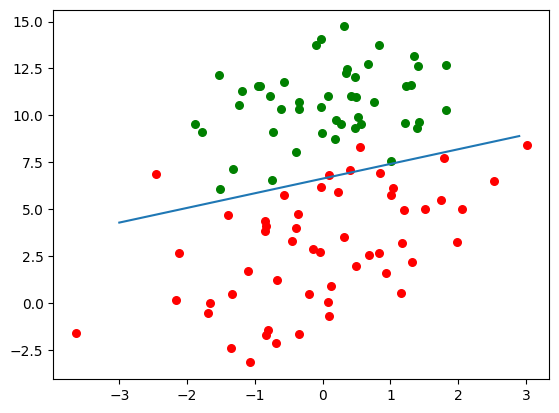

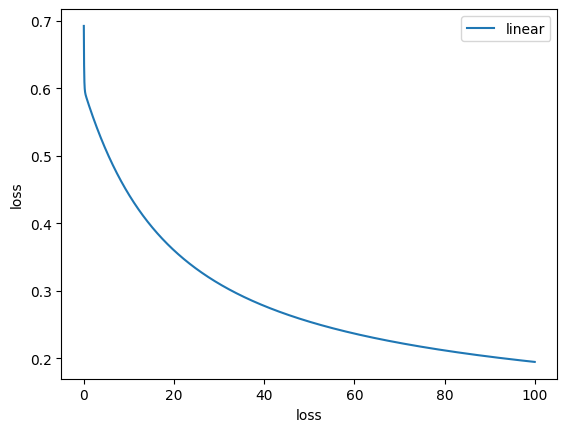

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np

#导入数据
def loadDatasets():
    data=[]
    labels=[]
    with open("dataset/logisticDataset.txt","r") as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            data.append([1.0, float(row[0]), float(row[1])])
            labels.append(int(row[2]))
    return data, labels

# 用图形表示训练集
def plotBestFit(W):
    dataMat, labelMat = loadDatasets()
    dataArr = np.array(dataMat)
    n = dataArr.shape[0]
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red')
    ax.scatter(xcord2, ycord2, s=30, c='green')

    #画出分类边界
    x = np.arange(-3.0,3.0, 0.1)
    y = (-W[0]-W[1]*x)/W[2]
    ax.plot(x, y)
    plt.show()

def plotloss(loss_list):
    x = np.arange(0, len(loss_list)//100, 0.01)
    plt.plot(x,np.array(loss_list),label='linear')

    plt.xlabel('loss')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def main(learning_rate, num_iterations):
    # 读取训练集
    data, label = loadDatasets()

    X = np.array(data)

    y = np.array(label).reshape(-1,1)

    W = 0.001*np.random.randn(3,1).reshape(-1,1)

    m = len(X)

    loss_his = []

    for i in range(num_iterations):
        g_x = np.dot(X,W)
        h_x = 1/(1+np.exp(-g_x))
        loss = y*np.log(h_x) + (1-y)*np.log(1-h_x)
        loss = -np.sum(loss)/m
        loss_his.append(loss)

        dW = X.T.dot(h_x-y)/m
        W -= dW*learning_rate
    
    print("计算得到的最优解：")
    print(W)
    plotBestFit(W)
    plotloss(loss_his)


if __name__ == '__main__':
    main(0.005, 10000)

In [2]:
import GDoptimizer
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iteratons=1000):
        self.learning_rate=learning_rate
        self.num_iteratons = num_iteratons
        self.w = None
    
    def initialize_weights(self, num_features):
        limit = np.sqrt(1/num_features)
        w = np.random.uniform(-limit, limit, (num_features, 1))
        b = 0
        self.w = np.insert(w, 0, b, axis=0)
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def fit(self, X, y, optimizer = GDoptimizer.SGD()):
        num_samples, num_features = X.shape
        self.initialize_weights(num_features)
        #添加x0
        X_hat = np.insert(X, 0, 1, axis=1)
        y = np.reshape(y,(num_samples,1))

        for _ in range(self.num_iteratons):
            h_x = X_hat.dot(self.w)
            y_pred = self.sigmoid(h_x)
            w_grad = X_hat.T.dot(y_pred - y)
            optimizer.update(self.w, 0.0, w_grad,0.0 )
            # self.w -= self.learning_rate*w_grad

    def predict(self, X):
        X_hat = np.insert(X, 0, 1, axis =1)
        h_x = X_hat.dot(self.w)
        y_pred = np.round(self.sigmoid(h_x))
        return y_pred.astype(int)

In [3]:
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)

def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def calculate_std_dev(X):
    """ Calculate the standard deviations of the features in dataset X """
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)


def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

In [4]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()




0.8275862068965517


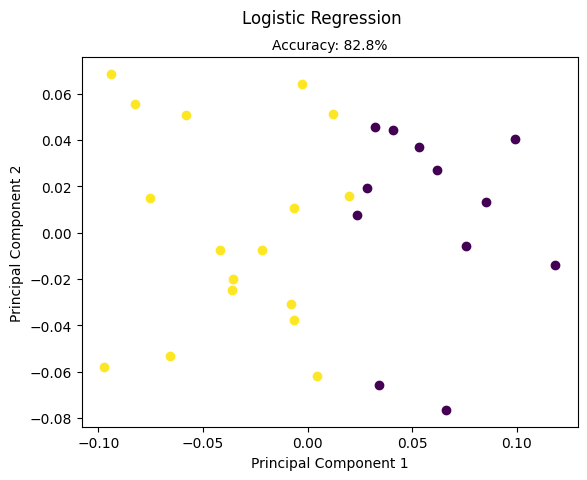

In [5]:
from sklearn import datasets
data = datasets.load_iris()
X = normalize(data.data[data.target!=0])
y= data.target[data.target!=0]
y[y==1] = 0
y[y==2] = 1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, seed=1)
model = LogisticRegression(learning_rate=0.1, num_iteratons=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,y_test.shape)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Plot().plot_in_2d(X_test, y_pred, title='Logistic Regression', accuracy=accuracy)

In [6]:
Data = datasets.load_iris()
_data  = Data.data
_target = Data.target
X = Data.data[Data.target!=0]
X = normalize(X)
y = Data.target[Data.target!=0]
model = LogisticRegression(learning_rate=0.01, num_iteratons=10000)
model.fit(X, y)
print(model.w)



[[5000.57085779]
 [3523.28386587]
 [1594.54371014]
 [2969.05033506]
 [1086.94563055]]


[5000.54849408]

[3523.13704261]

[1594.87653305]

[2968.60175639]

[1086.54757898]

In [7]:
import GDoptimizer
import numpy as np

class LogisticRegression:
    def __init__(self):
        self.w = None
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def init_weights(self, num_features):
        limits = 1/np.sqrt(num_features)
        self.w = np.random.uniform(-limits,limits,(num_features+1,1))
        self.w[0]=0

    def fit(self, X, y, num_iteration=5000, optimizer=GDoptimizer.SGD()):
        num_samples, num_features = X.shape
        self.init_weights(num_features)

        X_hat = np.insert(X, 0, 1, axis=1)
        y_hat = np.reshape(y, (num_samples, 1))

        for _ in range(num_iteration):
            grad = self.grad(X_hat, y_hat)
            optimizer.update(self.w, 0.0,grad,0.0)

    def grad(self, X, y, regularization_param=0.05):
        h_x = X.dot(self.w)
        y_pred = self.sigmoid(h_x)
        regularization_term = (regularization_param/X.shape[0])*self.w
        return X.T.dot(y_pred-y)/X.shape[0] + regularization_term
    
    def predict(self, X):
        X_hat = np.insert(X,0,1,axis=1)
        y = self.sigmoid(-(X_hat.dot(self.w)))
        y = np.round(y)
        y.astype('int')
        return y

In [8]:
import matplotlib.pyplot as plt
import csv
import numpy as np

#导入数据
def loadDatasets():
    data=[]
    labels=[]
    with open("dataset/logisticDataset.txt","r") as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            data.append([float(row[0]), float(row[1])])
            labels.append(int(row[2]))
    return data, labels

data,labels = loadDatasets()
data = np.array(data[:])
labels = np.array(labels[:])

model = LogisticRegression()
model.fit(data, labels,num_iteration=10000)

100
[[ 5.18806445]
 [ 0.56599124]
 [-0.75146404]]


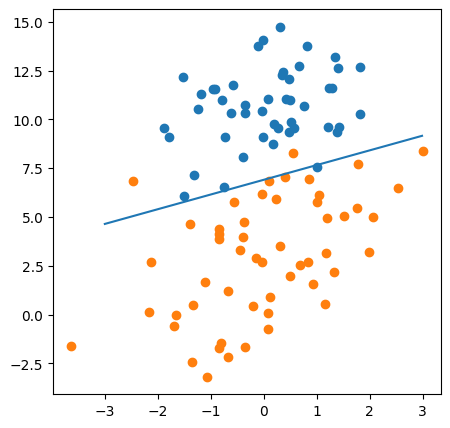

In [9]:
xcord1 = []
ycord1 = []
xcord2 = []
ycord2 = []

for i in range(len(data)):
    if labels[i]==0:
        xcord1.append(data[i][0])
        ycord1.append(data[i][1])
    if labels[i]==1:
        xcord2.append(data[i][0])
        ycord2.append(data[i][1])

print(len(data))

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.scatter(xcord1,ycord1)
ax.scatter(xcord2,ycord2)

w = model.w
x = np.arange(-3.0,3.0,0.01)
print(w)
y = (-w[1]*x-w[0])/w[2]
ax.plot(x,y)



plt.show()

In [20]:
class MultiLogisticRegresstion:

    def __init__(self):
        self.w = None
    
    def softmax(self,x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T

        x = x - np.max(x)  # 溢出对策
        return np.exp(x) / np.sum(np.exp(x))


    def compute_prob(self,X):
        scores = X.dot(self.w)
        return self.softmax(scores)
    
    def compute_grad(self,X,y,regularization_param):
        num_samples = X.shape[0]
        probs = self.compute_prob(X)
        grad = -(1/num_samples)*X.T.dot(np.eye(self.w.shape[1])[y]-probs)
        regularization_term = regularization_param/num_samples*self.w
        grad+=regularization_term
        return grad 
    
    def initialize_weights(self,num_samples, num_features):
        limits = 1/np.sqrt(num_samples**2+num_features**2)
        self.w = np.random.uniform(-limits,limits,(num_features+1,num_samples))
    
    def fit(self,X,y,num_iterations=5000,regularization_param=0.01,batch_size=8,optimizer=GDoptimizer.SGD()):
        num_samples, num_features = X.shape
        X_hat = np.insert(X,0,1,axis=1)
        y_hat = y
        self.initialize_weights(num_samples, num_features)

        for i in range(num_iterations):
            mask = np.random.choice(num_samples,batch_size)
            x_batch = X_hat[mask]
            y_batch = y_hat[mask]
            grad = self.compute_grad(x_batch,y_batch,regularization_param)
            optimizer.update(self.w,0,grad,0)
    
    def predict(self,X):
        X_hat = np.insert(X,0,1,axis=1)
        y_pred = self.compute_prob(X_hat)
        return np.argmax(y_pred, axis=1)


In [23]:
Data = datasets.load_iris()
data  = Data.data
target = Data.target
model = MultiLogisticRegresstion()
model.fit(data,target,num_iterations=10000)
y_pred = model.predict(data)



In [24]:
print(y_pred-target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
